In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import shap
import keras.backend as K
import json

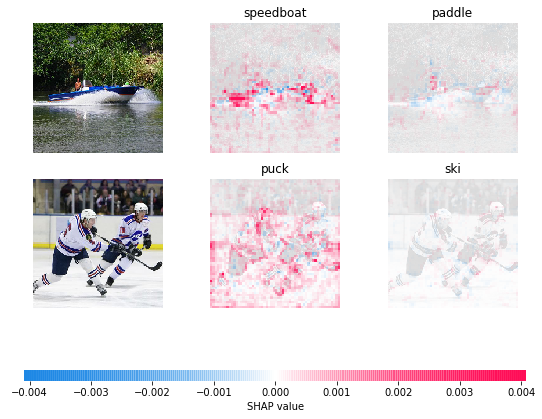

In [4]:

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True) ## CHANGE INCLUDE TOP TO FALSE
X,y = shap.datasets.imagenet50()
to_explain = X[[2,3]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

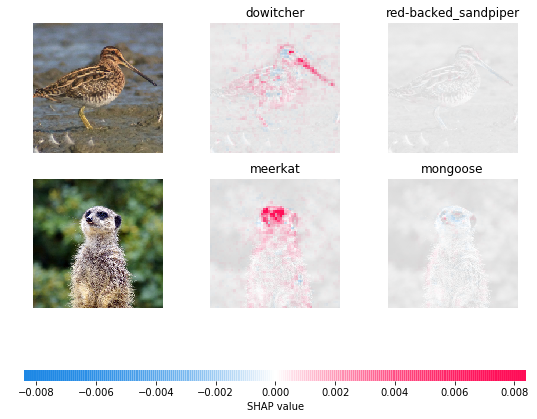

In [2]:
shap.image_plot(shap_values, to_explain, index_names)

In [6]:
img_width = 150
img_height = 150
batch_size =16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = ImageDataGenerator(rescale=1. / 255)


# The generator object. 
train_generator = train_datagen.flow_from_directory(
    './data/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    './data/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

array([['speedboat', 'paddle'],
       ['puck', 'ski']], dtype='<U9')

In [ ]:
def add_new_last_layer(base_model, nb_classes=2):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    # Get the output shape of the models last layer
    x = base_model.output
    # Convert final MxNxC tensor output into a 1xC tensor where C is the # of channels.
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(.5)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
# This will freeze the weights on all the layers except for our new dense layer
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [ ]:
tran_model = add_new_last_layer(base_model)
setup_to_transfer_learn(tran_model,base_model)

In [ ]:
nb_epoch = 15

tran_model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=10)

In [ ]:
img = load_img('./data/test/hot_dog/197257.jpg',target_size=(150,150) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
img.shape

In [ ]:
pred = tran_model.predict(img)
pred

In [ ]:
np.round(pred, decimals=3)